# Comparison of temporal super-resolution networks on in-silico data

This notebook serves a comparison framework for different networks, e.g. focusing on different loss functions or architectures. Important to note that the HR (ground truth) is the same for all networks. 

In [1]:
#%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from IPython.display import display
import pandas as pd
from collections import defaultdict
plt.rcParams['figure.figsize'] = [10, 8]

import sys
sys.path.insert(0, '../../src')

from utils.evaluate_utils import *


%matplotlib inline

In [2]:
#display models
df = pd.read_csv('../../results/Overview_models.csv')
df1 = df[['Name', 'notes']]
pd.set_option("max_colwidth", None)
display(df1)

,Name,notes
0,Temporal4DFlowNet_20230210-0333,NaN
1,Temporal4DFlowNet_20230215-1029,NaN
2,Temporal4DFlowNet_20230217-0602,NaN
3,Temporal4DFlowNet_20230220-0908,NaN
4,Temporal4DFlowNet_20230301-1127,First training on radial sampled data
...,...,...
107,Temporal4DFlowNet_20240807-1745,"CS data (more noise 14-17db + include first two frames), HR: original CFD, LR: CFD to MR pipeline, also train on models 2,3,5,6 with invivo magn, note validation=test set, fixed loss"
108,Temporal4DFlowNet_20240827-1704,"CS data (more noise 14-17db + include first two frames), HR: original CFD, LR: CFD to MR pipeline, also train on models 2,3,5,6 with invivo magn, note validation=test set, fixed loss, lr decay (50 epochs)"
109,Temporal4DFlowNet_20240827-1709,"CS data (more noise 14-17db + include first two frames), HR: original CFD, LR: CFD to MR pipeline, also train on models 2,3,5,6 with invivo magn, note validation=test set, fixed loss, alpha = 0.5"
110,Temporal4DFlowNet_20240827-1711,"CS data (more noise 14-17db + include first two frames), HR: original CFD, LR: CFD to MR pipeline, also train on models 2,3,5,6 with invivo magn, note validation=test set, fixed loss, alpha = 0.9"


Setting the network names and their description in the next plots and evaluation tabulars. 

In [4]:
# 20230407-2246
# model_names  = ['20230301-1641', '20230301-1654', '20230301-1704', '20230305-1001', '20230305-1002', '20230305-1008', '20230305-1107'     , '20230306-1120']
# tabular_names = ['ResNet_8_4'   , 'DenseNet_8_4' , 'CSPNet_8_4'   , 'ResNet_4_2'   ,'ResNet_6_6'    , 'ResNet_4_8'   , 'ResNet_Conv3DT_8_4', 'ResNet_NN_8_4']
# ['20230405-1417']
# model_names = ['20230405-1417', '20230620-0909',   ]#'20230619-1655', '20230619-1711']
# tabular_names = ['Baseline', 'BaselineMoreEpochs', ]#'BaselineLRDecay', 'BaselineNoL2Reg']
#'20230405-1417'
# model_names = ['20230620-0909', '20230405-1419', '20230405-1421','20230407-2222']  #['20230405-1417', '20230313-0948', '20230313-0949','20230404-1418', '20230405-1419','20230405-1421', '20230405-1422' ,'20230405-1423', '20230406-1601'  ]#['20230308-1226', '20230313-0948', '20230313-0949','20230313-0951','20230315-1509' ]#'*', '20230313-0951']#['20230301-1641', '20230301-1654', '20230301-1704', '20230305-1001', '20230305-1002', '20230305-1008', '20230305-1107'     , '20230306-1120']
# tabular_names = ['ResNet 8-4' , 'ResNet 4-8', 'ResNet 10-6', 'ResNet 4-2']

# model_names = ['20230508-1433', '20230602-1701' ]
# tabular_names = ['OriginalModel', 'OriginalModelMoreEpochs']
# model_names = ['20230405-1417', '20230620-0909', '20230619-1655', '20230619-1711' ]  # #['20230405-1417', '20230313-0948', '20230313-0949','20230404-1418', '20230405-1419','20230405-1421', '20230405-1422' ,'20230405-1423', '20230406-1601'  ]#['20230308-1226', '20230313-0948', '20230313-0949','20230313-0951','20230315-1509' ]#'*', '20230313-0951']#['20230301-1641', '20230301-1654', '20230301-1704', '20230305-1001', '20230305-1002', '20230305-1008', '20230305-1107'     , '20230306-1120']
# tabular_names = ['ResNetOriginal', 'ResNet longer epochs', 'weight decay', 'Resnet no l2 regularization']# 
# model_names = ['20230405-1417', '20230405-1419', '20230405-1421','20230407-2222', '20230405-1423', '20230405-1422',  '20230404-1418', '20230407-2228', '20230407-2230', '20230407-2246']#['20230405-1417', '20230313-0948', '20230313-0949','20230404-1418', '20230405-1419','20230405-1421', '20230405-1422' ,'20230405-1423', '20230406-1601'  ]#['20230308-1226', '20230313-0948', '20230313-0949','20230313-0951','20230315-1509' ]#'*', '20230313-0951']#['20230301-1641', '20230301-1654', '20230301-1704', '20230305-1001', '20230305-1002', '20230305-1008', '20230305-1107'     , '20230306-1120']
# tabular_names = ['ResNet-8-4' , 'ResNet_4-8', 'ResNet_10-6', 'ResNet_4-2','ResNet_TranspConv3D', 'ResNet_NN', 'ResNet_Unet',  'DenseNet', 'CSPNet', 'ResNet_ResNet_Unet']#['ResNet_8_4',  'DenseNet_8_4', 'CSPNet_8-4', 'ResNet_Unet','ResNet_4_8','ResNet_10_6', 'ResNet_NN', 'ResNet_Conv3DT', 'ResNet_Post_Unet' ]#['Dyn_ResNet', 'Dyn_DenseNet', 'Dyn_SCPNet', 'Dyn_ResNet_Conv3DT', 'Dyn_ResNet_4_8']    #, 'Dyn_CSPNet']#['ResNet_8_4'   , 'DenseNet_8_4' , 'CSPNet_8_4'   , 'ResNet_4_2'   ,'ResNet_6_6'    , 'ResNet_4_8'   , 'ResNet_Conv3DT_8_4', 'ResNet_NN_8_4']
# model_names  =  ['20230405-1417','20230425-1654', '20230425-1715', '20230425-1719']#['20230405-1417', '20230427-1204', '20230427-1207']#['20230405-1417','20230425-1654', '20230425-1715', '20230425-1719'	 ]#['20230405-1417', '20230405-1419', '20230405-1421','20230407-2222', '20230405-1423', '20230405-1422',  '20230404-1418', '20230407-2228', '20230407-2230', '20230407-2246']#['20230405-1417', '20230313-0948', '20230313-0949','20230404-1418', '20230405-1419','20230405-1421', '20230405-1422' ,'20230405-1423', '20230406-1601'  ]#['20230308-1226', '20230313-0948', '20230313-0949','20230313-0951','20230315-1509' ]#'*', '20230313-0951']#['20230301-1641', '20230301-1654', '20230301-1704', '20230305-1001', '20230305-1002', '20230305-1008', '20230305-1107'     , '20230306-1120']
# tabular_names = ['ResNet_ResNet', 'LSTM_ResNet', 'LSTM_LSTM', 'ResNet_LSTM']#['TrainM2M3-ValM1', 'TrainM1M3-ValM2', 'TrainM1M2-ValM3' ] #['ResNet_ResNet', 'LSTM_ResNet', 'LSTM_LSTM', 'ResNet_LSTM'] #['ResNet-8-4' , 'ResNet_4-8', 'ResNet_10-6', 'ResNet_4-2','ResNet_TranspConv3D', 'ResNet_NN', 'ResNet_Unet',  'DenseNet', 'CSPNet', 'ResNet_ResNet_Unet']#['ResNet_8_4',  'DenseNet_8_4', 'CSPNet_8-4', 'ResNet_Unet','ResNet_4_8','ResNet_10_6', 'ResNet_NN', 'ResNet_Conv3DT', 'ResNet_Post_Unet' ]#['Dyn_ResNet', 'Dyn_DenseNet', 'Dyn_SCPNet', 'Dyn_ResNet_Conv3DT', 'Dyn_ResNet_4_8']    #, 'Dyn_CSPNet']#['ResNet_8_4'   , 'DenseNet_8_4' , 'CSPNet_8_4'   , 'ResNet_4_2'   ,'ResNet_6_6'    , 'ResNet_4_8'   , 'ResNet_Conv3DT_8_4', 'ResNet_NN_8_4']


model_names = ['20240207-1150', '20240124-1757', '20240212-1107', '20240212-1109', '20240212-1555', '20240212-1612', '20240206-1809']
tabular_names = [f'MSE loss', 'MAE loss'       , 'comb. mutal. proj.(w=0.5,a=0.5)', 'comb. mutal. proj.(w=0,a=0.5)', 'mut. proj(0.2) with mse (0.8)', 'cosine sim.(0.2) with mse (0.8)', 'huber loss (delta=0.05)' ]
 
title_comparison = 'Comparison of Loss Functions'
set_name = 'Validation'               
data_model= '1'
step = 2
use_dyn_mask = True
load_interpolation = False

eval_dir = '../../results/plots/ComparisonPlots_lossfct_TBD/'


### Define helper functions


In [11]:
vel_colnames=['u', 'v', 'w']
vel_colnames_fluid = ['u_fluid', 'v_fluid', 'w_fluid']


#directories
gt_dir = '../../data/CARDIAC'
result_dir = f'../../results/'
eval_dir = f'{result_dir}/plots'
lr_dir = '../../data/CARDIAC'

if not os.path.isdir(eval_dir): os.makedirs(eval_dir)


inbetween_string = ''
if use_dyn_mask: inbetween_string = '_dynamic'

#filenames
lr_filename = f'M{data_model}_2mm_step{step}_invivoP01_magn_temporalsmoothing_toeger_periodic_LRfct_noise.h5'
gt_filename = f'M{data_model}_2mm_step{step}_invivoP01_magn_temporalsmoothing_toeger_periodic_HRfct.h5'
# gt_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}.h5' #f'M{data_model}_2mm_step{step}_invivoP02_magnitude.h5'#f'M{data_model}_2mm_step{step}_static{inbetween_string}.h5'
# lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5'#f'M{data_model}_2mm_step{step}_invivoP02_magnitude_noisy.h5'#f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5'

# Setting up
gt_filepath = '{}/{}'.format(gt_dir, gt_filename)
lr_filepath = '{}/{}'.format(lr_dir, lr_filename)

# load data HR and LR
gt = load_velocity_data(gt_filepath, {}, vel_colnames, load_mask = True)
lr = load_velocity_data(lr_filepath, {}, vel_colnames, load_mask = False)

# if lr not downsampled yet (only noise added)
if lr['u'].shape[0] == gt['u'].shape[0]:
    offset = 0
    for vel in vel_colnames:
        lr[vel] = lr[vel][offset::2, :, :, :]


# add information considering only the fluid regions and set regions outside the mask to zero
for vel in vel_colnames:
    lr[f'{vel}_fluid'] = np.multiply(lr[vel], gt['mask'][offset::2])
    gt[f'{vel}_fluid'] = np.multiply(gt[vel], gt['mask'])

# include speed calculations
gt['speed'] = np.sqrt(gt["u"]**2 + gt["v"]**2 + gt["w"]**2)
lr['speed'] = np.sqrt(lr["u"]**2 + lr["v"]**2 + lr["w"]**2)


if load_interpolation: 
    #TODO: revise interpolation methods

    interpolate_NN = load_vel_interpolation({},lr, f'{result_dir}/interpolation/{lr_filename}_interpolate_NN.h5', 'nearest', gt['mask'], vel_colnames, savefile = False)
    interpolate_linear = load_vel_interpolation({},lr, f'{result_dir}/interpolation/{lr_filename}_interpolate_linear.h5', 'linear', gt['mask'], vel_colnames, savefile = False)
    interpolate_cubic = load_vel_interpolation({},lr, f'{result_dir}/interpolation/{lr_filename}_interpolate_cubic.h5', 'cubic', gt['mask'], vel_colnames, savefile = False)
    interpolate_sinc = load_vel_interpolation({},lr, f'{result_dir}/interpolation/{lr_filename}_interpolate_sinc.h5', 'sinc', gt['mask'], vel_colnames, savefile = False)

# this is the syntax how most of the prediction files are names, and can be adapted for other nameconventions
def get_pred_filepath(model_name, set_name, data_model, step, ending_file = ''):
    return f'{result_dir}Temporal4DFlowNet_{model_name}/{set_name}set_result_model{data_model}_2mm_step{step}_{model_name[-4::]}_temporal{ending_file}.h5' 

def calculate_rmse_jupyter(pred,gt, binary_mask, return_std= False):
    '''
    Calculate root mean squared error between prediction and ground truth for each frame
    i.e. rmse(t) = sqrt((pred - gt)**2/N), where N number of point in fluid region
    If return_std is set to true, the standard deviation of (pred - gt)**2 is returned as well
    '''
    pred = pred.squeeze()
    gt = gt.squeeze()
    if len(pred.shape)==3: pred = np.expand_dims(pred, 0)
    if len(gt.shape)==3:  gt = np.expand_dims(gt, 0)
    
    if len(binary_mask.squeeze().shape) ==3:
        print('Create temporal mask for RMSE caculation', binary_mask.shape, pred.shape, gt.shape )
        binary_mask = create_dynamic_mask(binary_mask, pred.shape[0])
        print('Reshaped to', binary_mask.shape)
    
    binary_mask[np.where(binary_mask > 0.5)] = 1
    binary_mask[np.where(binary_mask <= 0.5)] = 0
    
    bool_mask = np.equal(binary_mask, 1.0)
    points_in_mask = np.where(binary_mask !=0)

    reshaped_pred = pred[:, points_in_mask[1], points_in_mask[2], points_in_mask[3]].reshape(gt.shape[0], -1)
    reshaped_gt     = gt[:, points_in_mask[1], points_in_mask[2], points_in_mask[3]].reshape(gt.shape[0], -1)

    rmse = np.sqrt(np.mean((reshaped_pred - reshaped_gt)**2, axis = (-1)))
    
    # rmse = np.sqrt(np.mean((reshaped_pred - gt)**2, axis = (1, 2, 3), where=bool_mask))
    
    if return_std:
        #std(a) = sqrt(mean(x)), where x = abs(a - a.mean())**2.
        var = np.std((pred - gt)**2, axis = (1, 2, 3), where=bool_mask)
        # var = np.std((reshaped_pred - np.repeat(np.expand_dims(np.mean(reshaped_gt, axis=1), -1), reshaped_pred.shape[1], axis = 1))**2, axis = 1) 
        return rmse, var
    return rmse


def get_RMSE_k_R2(results, prediction, ground_truth,temporal_mask, t_peak_flow):
    '''
    Append error variables RMSE (avg and std), k, r'2,  into dict 
    '''
    directions = ['x', 'y', 'z']
    vel_colnames = ['u', 'v', 'w']
    for direction, vel in zip(directions, vel_colnames):
        RMSEi= calculate_rmse_jupyter(prediction[f'{vel}_fluid'][t_peak_flow], ground_truth[f'{vel}_fluid'][t_peak_flow], temporal_mask[t_peak_flow], return_std = False)
        # RMSEi, _ = calculate_rmse_jupyter(prediction[f'{vel}_fluid'][t_peak_flow], ground_truth[f'{vel}_fluid'][t_peak_flow], temporal_mask[t_peak_flow], return_std = False)

        results[f'RMSE{direction}'].append(RMSEi[0])
        # results[f'RMSE{direction}_std'].append(std[0])
        k, R2 = calculate_k_R2(prediction[vel][t_peak_flow], ground_truth[vel][t_peak_flow], temporal_mask[t_peak_flow])
        results[f'k{direction}'].append(k)
        results[f'R_2{direction}'].append(R2)
    
    results['RE'].append(calculate_relative_error_normalized(prediction["u"], prediction["v"], prediction["w"], ground_truth["u"], ground_truth["v"] , ground_truth["w"], ground_truth["mask"])[t_peak_flow])

    return results

### Tabulate plots

In [12]:

dict_results = defaultdict(list)


N_frames = gt['u'].shape[0]
peak_flow_frame = np.unravel_index(np.argmax(gt['speed']), shape = gt['speed'].shape)[0]
print("Peak flow frame:", peak_flow_frame)
if peak_flow_frame%2 == 0: 
    peak_flow_frame +=1
    print("Peak flow frame changed to:", peak_flow_frame)


if True:
    ending_file = ''
    for m_name, t_name in zip(model_names, tabular_names):
        result_filename = get_pred_filepath(m_name, set_name, data_model, step) #_newpadding

        pred = load_velocity_data(result_filename, {}, ['u_combined', 'v_combined', 'w_combined'], load_mask = False)
        for vel in vel_colnames:
            pred[f'{vel}_fluid'] = np.multiply(pred[vel], gt['mask'])
        dict_results['Network'].append(t_name)
        dict_results = get_RMSE_k_R2(dict_results,pred,gt, gt['mask'],peak_flow_frame) #evaluate

gt['mean_speed'] = calculate_mean_speed(gt["u_fluid"], gt["v_fluid"] , gt["w_fluid"], gt["mask"])

# load interpolation files and evaulate those with given data
if load_interpolation: 
    interpolate_linear, interpolate_cubic, interpolate_NN = load_interpolation(data_model, step,lr, gt, use_dynamical_mask = use_dyn_mask)

    dict_results['Network'].append('Linear interpolation')
    dict_results = get_RMSE_k_R2(dict_results,interpolate_linear,gt,gt['mask'], peak_flow_frame)

    dict_results['Network'].append('Cubic interpolation')
    dict_results = get_RMSE_k_R2(dict_results,interpolate_cubic,gt,gt['mask'], peak_flow_frame)

    rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
    rel_error_cubic_interpolation = calculate_relative_error_normalized(interpolate_cubic["u"], interpolate_cubic["v"], interpolate_cubic["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])


r_dt = pd.DataFrame(dict_results).round(4)
display(r_dt)

Peak flow frame: 9
Create temporal mask for RMSE caculation (71, 69, 75) (1, 71, 69, 75) (1, 71, 69, 75)
Create static temporal mask.
Reshaped to (1, 71, 69, 75)


AttributeError: module 'scipy' has no attribute 'stats'

In [16]:
# rearange columns for better readability and print for latex
rearaanged_columns = ['Network', 'RMSEx','RMSEx_std', 'RMSEy','RMSEy_std', 'RMSEz',   'RMSEz_std', 'kx', 'ky', 'kz', 'R_2x', 'R_2y', 'R_2z', 'RE']
r_dt = r_dt[rearaanged_columns]

#Print for latex tabular
print(r_dt.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
Network & RMSEx & RMSEx_std & RMSEy & RMSEy_std & RMSEz & RMSEz_std & kx & ky & kz & R_2x & R_2y & R_2z & RE \\
\midrule
MSE loss & 0.02 & 0.00 & 0.02 & 0.00 & 0.02 & 0.00 & 0.97 & 0.93 & 0.97 & 0.98 & 0.98 & 0.97 & 22.14 \\
MAE loss & 0.03 & 0.00 & 0.02 & 0.00 & 0.02 & 0.00 & 0.95 & 0.95 & 0.95 & 0.98 & 0.97 & 0.97 & 24.78 \\
comb. mutal. proj.(w=0.5,a=0.5) & 0.02 & 0.00 & 0.02 & 0.00 & 0.02 & 0.00 & 0.97 & 0.91 & 0.95 & 0.98 & 0.96 & 0.97 & 24.91 \\
comb. mutal. proj.(w=0,a=0.5) & 0.02 & 0.00 & 0.02 & 0.00 & 0.02 & 0.00 & 0.96 & 0.93 & 0.96 & 0.98 & 0.97 & 0.97 & 26.95 \\
mut. proj(0.2) with mse (0.8) & 0.02 & 0.00 & 0.02 & 0.00 & 0.02 & 0.00 & 0.98 & 0.97 & 0.98 & 0.98 & 0.97 & 0.98 & 22.15 \\
cosine sim.(0.2) with mse (0.8) & 0.12 & 0.02 & 0.11 & 0.02 & 0.14 & 0.02 & 1.01 & 1.26 & 1.12 & 0.71 & 0.59 & 0.59 & 72.88 \\
huber loss (delta=0.05) & 0.02 & 0.00 & 0.02 & 0.00 & 0.02 & 0.00 & 0.96 & 0.97 & 0.97 & 0.98 & 0.97 & 0.97 & 21.57 \\
\bottom

In [17]:
vel_colnames = ['u', 'v', 'w']
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(gt[vel][np.where(gt['mask'] !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(gt[vel][np.where(gt['mask'] !=0)].flatten(), 0.99)

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
             Network &  RMSEx &  RMSEy &  RMSEz &  RMSEx\_std &  RMSEy\_std &  RMSEz\_std &     kx &     ky &     kz &   R\_2x &   R\_2y &   R\_2z &      RE \\
\midrule
          ResNet-8-4 & 0.0193  \pm 0.0506 & 0.0159 & 0.0177 &     &     0.0187 &     0.0406 & 0.9714 & 0.9693 & 0.9343 & 0.9770 & 0.9682 & 0.9648 & 19.6768 \\
          ResNet\_4-8 & 0.0219 \pm 0.0515  & 0.0153 & 0.0194 &    &     0.0173 &     0.0335 & 1.0014 & 0.9718 & 0.9115 & 0.9748 & 0.9707 & 0.9593 & 20.8026 \\
         ResNet\_10-6 & 0.0205 \pm 0.0536  & 0.0160 & 0.0192 &    &     0.0188 &     0.0374 & 0.9831 & 0.9828 & 0.9308 & 0.9741 & 0.9679 & 0.9585 & 20.1554 \\
          ResNet\_4-2 & 0.0197 \pm 0.0553  & 0.0161 & 0.0192 &    &     0.0186 &     0.0358 & 1.0031 & 0.9914 & 0.9088 & 0.9773 & 0.9696 & 0.9609 & 20.1167 \\
 ResNet\_TranspConv3D & 0.0205 \pm 0.0549  & 0.0157 & 0.0182 &    &     0.0180 &     0.0400 & 1.0011 & 0.9700 & 0.9409 & 0.9761 & 0.9685 & 0.9634 & 20.4221 \\
           ResNet\_NN & 0.0219 \pm 0.0568  & 0.0161 & 0.0188 &    &     0.0196 &     0.0374 & 1.0278 & 0.9878 & 0.9412 & 0.9747 & 0.9676 & 0.9599 & 20.7326 \\
         ResNet\_Unet & 0.0215 \pm 0.0554  & 0.0163 & 0.0195 &    &     0.0189 &     0.0372 & 1.0090 & 0.9903 & 0.9363 & 0.9769 & 0.9674 & 0.9581 & 21.0228 \\
            DenseNet & 0.0207  \pm 0.0555 & 0.0178 & 0.0199 &     &     0.0198 &     0.0357 & 1.0107 & 0.9984 & 0.9324 & 0.9763 & 0.9647 & 0.9568 & 21.6162 \\
              CSPNet & 0.0206  \pm 0.0529 & 0.0162 & 0.0189 &     &     0.0188 &     0.0370 & 0.9941 & 0.9794 & 0.9268 & 0.9743 & 0.9675 & 0.9601 & 19.9760 \\
  ResNet\_ResNet\_Unet & 0.019 \pm 0.0546 6 & 0.0149 & 0.0180 &   &     0.0178 &     0.0373 & 1.0075 & 0.9730 & 0.9287 & 0.9791 & 0.9720 & 0.9642 & 20.0434 \\
Linear interpolation & 0.0736  \pm 0.0734 & 0.0572 & 0.0745 &     &     0.0354 &     0.0680 & 0.9695 & 0.9664 & 0.9342 & 0.7341 & 0.6920 & 0.5798 & 36.7661 \\
 Cubic interpolation & 0.0934  \pm 0.1011 & 0.0729 & 0.0923 &     &     0.0518 &     0.0940 & 1.0319 & 1.0259 & 0.9965 & 0.6608 & 0.6094 & 0.5042 & 43.1786 \\
\bottomrule
\end{tabular}

### Plot loss values

In [18]:
if False:
    fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (8, 5))

    max_loss = 0
    min_loss = 10000

    for m_name, t_name in zip(model_names, tabular_names):
        if m_name != '20240212-1612' and m_name != '20240207-1150':
            
            loss = load_lossdata(f'../models/Temporal4DFlowNet_{m_name}/loss.csv')

            max_l = np.maximum(np.max(loss['val_accuracy']), np.max(loss['train_accuracy']))
            min_l = np.minimum(np.min(loss['val_accuracy']), np.min(loss['train_accuracy']))
            if max_l> max_loss: max_loss = max_l
            if min_l< min_loss: min_loss = min_l

            # Plot
            plt.subplot(1, 2, 1)
            plt.plot(loss['train_accuracy'], label = t_name)
            plt.xlabel('Epoch')
            plt.ylabel('Training RE')
            

            plt.subplot(1, 2, 2)
            plt.plot(loss['val_accuracy'], label = t_name) 
            plt.xlabel('Epoch')
            plt.ylabel('Validation RE')
            # plt.ylim(min_loss, max_loss)
        # load loss function
    plt.subplot(1, 2, 1)
    plt.ylim(min_loss-0.001, max_loss+0.001)
    plt.subplot(1, 2, 2)
    plt.ylim(min_loss-0.001, max_loss+0.001)
    plt.legend()

### Qualitative analysis

In [19]:
#Params for plot
patch_size = 1
show_avg = False
show_pixel = True

In [20]:

network_prediction = {}
error_pointwise = {}
for m_name, t_name in zip(model_names, tabular_names):
    network_prediction[t_name] = load_velocity_data(get_pred_filepath(m_name, set_name, data_model, step), network_prediction, ['u_combined', 'v_combined', 'w_combined'], load_mask = False)
    _, error_pointwise[t_name] = calculate_pointwise_error(network_prediction[t_name]['u'], network_prediction[t_name]['v'], network_prediction[t_name]['w'], gt["u"], gt["v"] , gt["w"], gt["mask"])

print(network_prediction.keys())
@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames)
def f(frame=5, x = 10, vel = "u"):
    plt.figure(figsize=(20,10))
    #N_row =  4 + len(model_names)
    N = 3 + len(model_names)
    idxs = np.index_exp[frame, x, :, :]

    plt.subplot(2, N, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, :, :],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, :, :]), vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("LR")
    plt.axis('off')

    plt.subplot(2, N, 2)
    plt.imshow(gt[vel][idxs], vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("GT")
    plt.axis('off')
    for i_1, t_name in enumerate(tabular_names):

        plt.subplot(2, N, 3+i_1)
        plt.imshow(network_prediction[t_name][vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
        plt.title(t_name)
        plt.axis('off')
    
    for i_2, t_name in enumerate(tabular_names):
        plt.subplot(2, N, N + 3 +i_2)
        plt.imshow(error_pointwise[t_name][vel][idxs],cmap= 'viridis')
        plt.axis('off')


    plt.tight_layout()
    # plt.subplots_adjust(hspace = 0.1)
    #plt.colorbar()
    # plt.show()

dict_keys(['u', 'v', 'w', 'MSE loss', 'MAE loss', 'comb. mutal. proj.(w=0.5,a=0.5)', 'comb. mutal. proj.(w=0,a=0.5)', 'mut. proj(0.2) with mse (0.8)', 'cosine sim.(0.2) with mse (0.8)', 'huber loss (delta=0.05)'])


interactive(children=(IntSlider(value=5, description='frame', max=49), IntSlider(value=10, description='x', ma…

NameError: name 'offset' is not defined

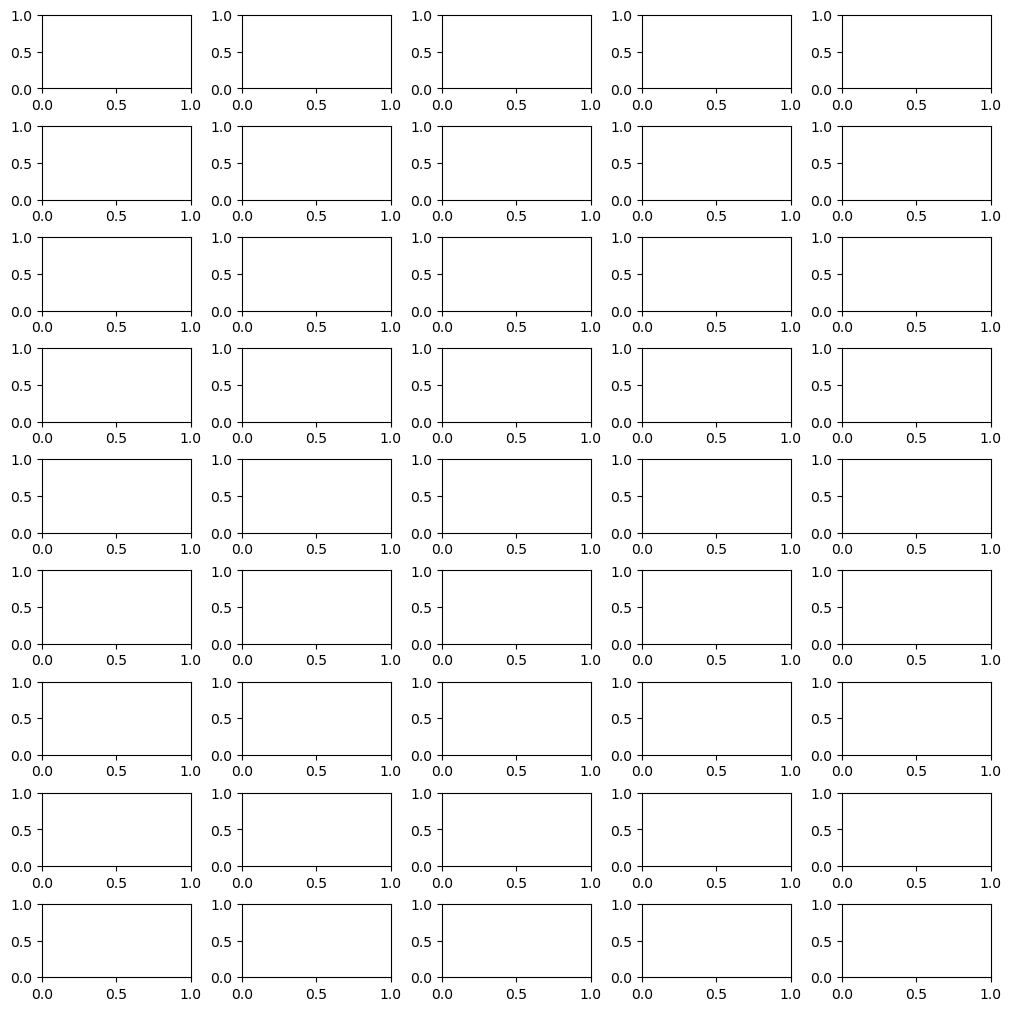

In [21]:


# network_prediction = {}
# for m_name, t_name in zip(model_names, tabular_names):
#     _, _, network_prediction[t_name],_, _ = load_data(m_name, set_name, data_model, step, dynamic_mask_used = use_dyn_mask) #load data
idx_cube = np.index_exp[:, :, 5:50, 10:70]
frames = [32, 33, 34, 35, 36]

comparison_plot_slices_over_time(gt['u'][idx_cube],lr['u'][idx_cube], gt['mask'][idx_cube], [network_prediction[t_name]['u'][idx_cube] for t_name in tabular_names], tabular_names, frames,axis=0, idx=22,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}_Qualitative_Frame_comparison_u.png")



## Quantitative analysis

In [22]:
# comparison_multiple_models(model_names, set_names, labels, colors,name_comparison, use_dyn_mask)
set_names = [set_name for _ in range(len(model_names))]
colors = [KI_colors['DarkPlum'], KI_colors['DarkBlue'], KI_colors['Orange'], KI_colors['Green'], KI_colors['Grey'], KI_colors['Plum'], KI_colors['DarkYellow']]
# colors = [KTH_colors['blue100'], KTH_colors['lightblue100'],  KTH_colors['grey100'], KTH_colors['pink80'], KTH_colors['grey40'],KTH_colors['grey80'],]#['steelblue', 'darkorange', 'brown', 'orchid', 'darkviolet', 'olivedrab', 'lightcoral', 'maroon', 'yellow', 'seagreen']
markers = ['solid', ':',  '--','-.',  (0, (3, 1, 1, 1)),'-.', '--']

Compare networks considering RMSE (||V||), Relative error (RE) and mean velocity

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


max/min before tanh 11684.372 0.0
max/min after tanh 1.0 0.0
max/min before tanh 10616.403 0.0
max/min after tanh 1.0 0.0
max/min before tanh 9249.976 0.0
max/min after tanh 1.0 0.0
max/min before tanh 5662.346 0.0
max/min after tanh 1.0 0.0
max/min before tanh 10468.721 0.0
max/min after tanh 1.0 0.0
max/min before tanh 49530.582 0.0
max/min after tanh 1.0 0.0
max/min before tanh 8012.7603 0.0
max/min after tanh 1.0 0.0


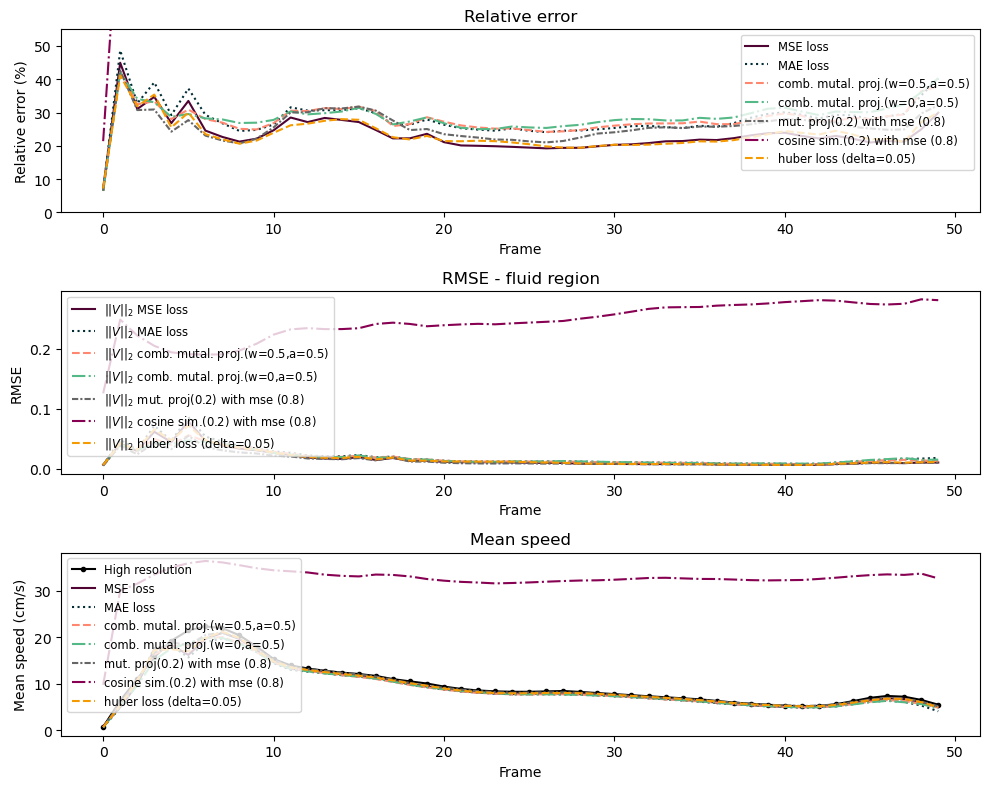

In [23]:

# ---helper functions for evaluation------
def calculate_absolute_error(u_sr, v_sr, w_sr, u_hr, v_hr, w_hr):
        return np.sum(np.abs(u_sr - u_hr) + np.abs(v_sr - v_hr) + np.abs(w_sr - w_hr), axis= (1, 2, 3))

def plot_comparison_RE_RMSE_MEANSPEED(ax, data,labels, color, marker):
    "Plot RE, RMSE, MEAN SPEED in one figure"
    ax[0].plot(data['RE'], label = labels['RE'], color = color, linestyle = marker)
    ax[1].plot(data['RMSE'], label = labels['RMSE'], color = color, linestyle = marker)
    ax[2].plot(data['mean_speed'], label = labels['mean_speed'], color = color, linestyle = marker)
    return ax

def init_RE_RMSE_MEANSPEED_plot(figsize, ylim = (0, 55)):
    fig, ax = plt.subplots(3, 1, figsize = figsize)
    ax[0].set_title(f"Relative error")
    ax[0].set_xlabel("Frame")
    ax[0].set_ylabel("Relative error (%)")
    ax[0].set_ylim(ylim)
    ax[0].legend(loc = 'upper right',fontsize='small')

    ax[1].set_ylabel('RMSE')
    ax[1].set_xlabel('Frame')
    ax[1].set_title('RMSE - fluid region')
    ax[1].legend(loc = 'upper left',fontsize='small')

    ax[2].set_xlabel("Frame")
    ax[2].set_ylabel("Mean speed (cm/s)")
    ax[2].set_title("Mean speed")
    ax[2].legend(loc = 'upper left',fontsize='small')
    return fig, ax


# ---plotting RE, RMSE, MEAN SPEED---
fig, ax = init_RE_RMSE_MEANSPEED_plot((10, 8))

# plot mean speed of HR
ax[2].plot(gt['mean_speed'],'.-', label ='High resolution',color = 'black')

for m_name, t_name, c, mark in zip(model_names, tabular_names, colors, markers):
    # prepare prediction data
    pred = load_velocity_data(get_pred_filepath(m_name, set_name, data_model, step), {}, ['u_combined', 'v_combined', 'w_combined'], load_mask = False)
    pred['speed'] = np.sqrt(pred["u"]**2 + pred["v"]**2 + pred["w"]**2)
    for vel in vel_colnames:
        pred[f'{vel}_fluid'] = np.multiply(pred[vel], gt['mask'])

    # calculate evaluation metrics
    eval_res = {}
    labels = {}
    eval_res['RE'] = calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
    eval_res['RMSE'] = calculate_rmse(pred['speed'], gt['speed'], gt['mask'])
    eval_res['mean_speed'] = calculate_mean_speed(pred["u_fluid"], pred["v_fluid"], pred["w_fluid"],gt["mask"])

    labels['RE'] = t_name
    labels['RMSE'] = fr'$||V||_2$ {t_name}'
    labels['mean_speed'] = t_name
    # plot
    ax = plot_comparison_RE_RMSE_MEANSPEED(ax, eval_res, labels, c, mark)

ax[0].legend(loc = 'upper right',fontsize='small')
ax[1].legend(loc = 'upper left',fontsize='small')
ax[2].legend(loc = 'upper left',fontsize='small')
plt.tight_layout()

plt.savefig(f'{eval_dir}/Comparison_RE_RMSE_MEANSPEED_{title_comparison}_{set_name}.svg',bbox_inches='tight')
plt.show()



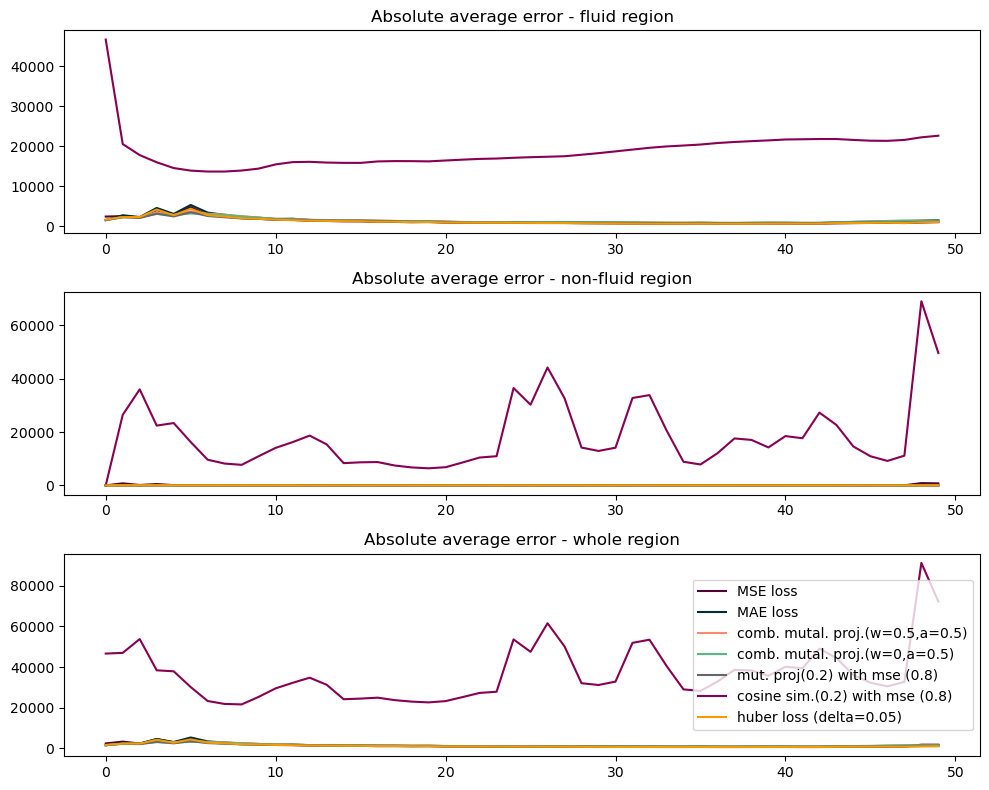

In [24]:
#TODO clean this up

# print(f'rel error {label}; mean: {np.mean(rel_err):.3f} ; max: {np.max(rel_err):.3f}, f: {np.argmax(rel_err)}')
# print(f'rmse {label}; mean: {np.mean(rmse):.3f} ; max: {np.max(rmse):.3f}, f: {np.argmax(rmse)}')
# print(f'mean speed {label}; mean: {np.mean(mean_speed):.3f} ; max: {np.max(mean_speed):.3f}, f: {np.argmax(mean_speed)}')
# print(f'mean speed deviation; mean: {np.mean(np.abs(mean_speed - gt["mean_speed"])):.3f} ; max: {np.max(np.abs(mean_speed - gt["mean_speed"])):.3f}, f: {np.argmax(np.abs(mean_speed - gt["mean_speed"]))}')
# print(f'Max abs difference speed {label}; max: {np.max(np.abs(prediction_1["speed"] - gt["speed"])):.3f}, f: {np.argmax(np.abs(prediction_1["speed"] - gt["speed"]))}')


def plot_abs_error(model_names, set_names,gt, labels, colors):
    
    for m_name, s_name, label, color in zip(model_names, set_names, labels, colors):
        
        pred = load_velocity_data(f'{result_dir}/Temporal4DFlowNet_{m_name}/{s_name}set_result_model{data_model}_2mm_step{step}_{m_name[-4::]}_temporal.h5', {}, ['u_combined', 'v_combined', 'w_combined'], load_mask = False)

        for vel in vel_colnames:
            pred[f'{vel}_fluid'] = np.multiply(pred[vel], gt['mask'])

        plt.subplot(3, 1, 1)
        plt.title(f"Absolute average error - fluid region")
        plt.plot(calculate_absolute_error(pred["u_fluid"], pred["v_fluid"], pred["w_fluid"], gt["u_fluid"], gt["v_fluid"] , gt["w_fluid"]), label = label, color= color)

        plt.subplot(3, 1, 2)
        plt.title(f"Absolute average error - non-fluid region")
        reverse_mask = np.ones_like(gt['mask']) - gt['mask']
        plt.plot(calculate_absolute_error(np.multiply(pred["u"], reverse_mask), np.multiply(pred["v"], reverse_mask), np.multiply(pred["w"], reverse_mask), np.multiply(gt["u"], reverse_mask), np.multiply(gt["v"], reverse_mask), np.multiply(gt["w"], reverse_mask)), label = label, color= color)

        plt.subplot(3, 1, 3)
        plt.title(f"Absolute average error - whole region")
        plt.plot(calculate_absolute_error(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"]), label = label, color= color)

    plt.tight_layout()

plot_abs_error(model_names, set_names, gt, tabular_names, colors)
plt.legend()

# Separate comparisons with individual focus (depth, loss, etc)

The code below aims for the fast qualitativ and quantitaive evaluation of different networks focusing of separate aspects. 

### Comparison depth resnet

In [27]:
model_names = ['20230620-0909', '20230710-1737', '20230710-1741', '20230710-1739']#['20230405-1417', '20230405-1419', '20230405-1421','20230407-2222']#['20230301-1641', '20230305-1001', '20230305-1002', '20230305-1008'] # resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name for _ in range(len(model_names))]
labels = ['ResNet 8-4' , 'ResNet 4-8', 'ResNet 10-6', 'ResNet 4-2']
# colors = ['steelblue', 'darkorange', 'brown', 'orchid', 'darkviolet']
name_comparison = 'Depth_MoreEpochs'
fig = plt.figure(figsize=(8, 9))
# comparison_multiple_models(model_names, set_names, labels, colors,'Depth',markers,  use_dyn_mask)

network_prediction = {}
for m_name, t_name in zip(model_names, labels):
    # _, _, network_prediction[t_name],_, _ = load_data(m_name, set_name, data_model, step, dynamic_mask_used = use_dyn_mask) #load data
    network_prediction[t_name] = load_velocity_data(get_pred_filepath(m_name, set_name, data_model, step), network_prediction, ['u_combined', 'v_combined', 'w_combined'], load_mask = False)
idx_cube = np.index_exp[:, :, 5:50, 10:60]
frames = [32, 33, 34, 35, 36]
comparison_plot_slices_over_time(gt['u'][idx_cube],lr['u'][idx_cube], gt['mask'][idx_cube], 0, [network_prediction[t_name]['u'][idx_cube] for t_name in labels], labels, frames, axis=0, idx=22,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_{name_comparison}_u_test.png", figsize=(8, 9))
comparison_plot_slices_over_time(gt['v'][idx_cube],lr['v'][idx_cube], gt['mask'][idx_cube], 0, [network_prediction[t_name]['v'][idx_cube] for t_name in labels], labels, frames, axis=0, idx=22,min_v = min_v['v'], max_v = max_v['v'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_{name_comparison}_v_test.png", figsize=(8, 9))
comparison_plot_slices_over_time(gt['w'][idx_cube],lr['w'][idx_cube], gt['mask'][idx_cube], 0, [network_prediction[t_name]['w'][idx_cube] for t_name in labels], labels, frames, axis=0, idx=22,min_v = min_v['w'], max_v = max_v['w'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_{name_comparison}_w_test.png", figsize=(8, 9))

# comparison_multiple_models(model_names, set_names, labels, colors,name_comparison, use_dyn_mask)
# compare_peak_flow_pixel(gt,lr, model_names, set_names, labels, colors,name_comparison,patch_size, show_avg, show_pixel, use_dynamical_mask = use_dyn_mask)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../../results/Temporal4DFlowNet_20230620-0909/Validationset_result_model1_2mm_step2_0909_temporal.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

<Figure size 800x900 with 0 Axes>

### Comparison sampling of data

In [ ]:
# model_names = ['20230301-1641','20230301-1127'] 
# set_names = [set_name for _ in range(len(model_names))]
# labels = [f'ResNet-Cartesian_Sampling_{set_names[0]}',f'ResNet_RadialSampling_{set_names[0]}']
# # colors = ['steelblue','darkorange', 'brown', 'orchid', 'darkviolet'] 
# name_comparison = 'RadialSampling'

# comparison_multiple_models(model_names, set_names, labels, colors, name_comparison)

# compare_peak_flow_pixel(gt,lr, model_names, set_names, labels, colors,name_comparison,patch_size, show_avg, show_pixel, use_dynamical_mask = use_dyn_mask)

### Comparison Upsampling layer

In [ ]:
model_names = ['20230620-0909','20230710-1800', '20230710-1803']#['20230405-1417', '20230405-1422',  '20230405-1423',]#['20230301-1641','20230305-1107', '20230306-1120']# resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name for _ in range(len(model_names))]
labels = [f'Linear', f'Nearest neigh.', f'TranspConv.']
# colors = ['steelblue','darkorange', 'brown', 'orchid', 'darkviolet'] 
name_comparison = 'upsampling_MoreEpochs'
# fig = plt.figure(figsize=(8, 9))
fig = plt.figure(figsize=(8, 9))
# comparison_multiple_models(model_names, set_names, labels, colors,'Upsampling',markers,  use_dyn_mask)


network_prediction = {}
for m_name, t_name in zip(model_names, labels):
    _, _, network_prediction[t_name],_, _ = load_data(m_name, set_name, data_model, step, dynamic_mask_used = use_dyn_mask) #load data
idx_cube = np.index_exp[:, :, 5:50, 10:70]
frames = [32, 33, 34, 35, 36]
comparison_plot_slices_over_time(gt['u'][idx_cube],lr['u'][idx_cube], gt['mask'][idx_cube], 0, [network_prediction[t_name]['u'][idx_cube] for t_name in labels], labels, frames, axis=0, idx=22,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_{name_comparison}_u_test.png", figsize=( 8, 5))
comparison_plot_slices_over_time(gt['v'][idx_cube],lr['v'][idx_cube], gt['mask'][idx_cube], 0, [network_prediction[t_name]['v'][idx_cube] for t_name in labels], labels, frames, axis=0, idx=22,min_v = min_v['v'], max_v = max_v['v'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_{name_comparison}_v_test.png", figsize=( 8, 5))
comparison_plot_slices_over_time(gt['w'][idx_cube],lr['w'][idx_cube], gt['mask'][idx_cube], 0, [network_prediction[t_name]['w'][idx_cube] for t_name in labels], labels, frames, axis=0, idx=22,min_v = min_v['w'], max_v = max_v['w'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_{name_comparison}_w_test.png", figsize=( 8, 5))
# comparison_multiple_models(model_names, set_names, labels, colors,name_comparison, use_dyn_mask)
# compare_peak_flow_pixel(gt,lr, model_names, set_names, labels, colors,name_comparison,patch_size, show_avg, show_pixel, use_dynamical_mask = use_dyn_mask)

### Comparison architecture components

In [ ]:
# model_names = ['20230405-1417', '20230404-1418', '20230407-2228', '20230407-2230', '20230407-2246', '20230711-0928']#['20230301-1641','20230301-1654', '20230301-1704'] ## resnet: Temporal4DFlowNet_20230301-1641 #
model_names = ['20230620-0909','20230710-1743', '20230710-1744','20230710-1748',  '20230710-1756','20230711-0928' ]
set_names = [set_name for _ in range(len(model_names))]
labels = [f'ResNet',   'DenseNet', 'CSPNet','Res_UNet', 'Res_Res_UNet', 'ConvLSTM']
# colors = ['steelblue','darkorange', 'brown', 'orchid', 'lightblue', 'navy', 'coral']
name_comparison = 'Architecture_MoreEpochs'
# fig = plt.figure(figsize=(9, 10))
fig = plt.figure(figsize=(8, 9))
# comparison_multiple_models(model_names, set_names, labels, colors,'Architecture',markers,  use_dyn_mask)

network_prediction = {}
for m_name, t_name in zip(model_names, labels):
    _, _, network_prediction[t_name],_, _ = load_data(m_name, set_name, data_model, step, dynamic_mask_used = use_dyn_mask) #load data
idx_cube = np.index_exp[:, :, 5:50, 10:70]
frames = [32, 33, 34, 35, 36]
comparison_plot_slices_over_time(gt['u'][idx_cube],lr['u'][idx_cube], gt['mask'][idx_cube], 0, [network_prediction[t_name]['u'][idx_cube] for t_name in labels], labels, frames, axis=0, idx=22,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_{name_comparison}_u_test.png", figsize=(8, 8))
comparison_plot_slices_over_time(gt['v'][idx_cube],lr['v'][idx_cube], gt['mask'][idx_cube], 0, [network_prediction[t_name]['v'][idx_cube] for t_name in labels], labels, frames, axis=0, idx=22,min_v = min_v['v'], max_v = max_v['v'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_{name_comparison}_v_test.png", figsize=(8, 8))
comparison_plot_slices_over_time(gt['w'][idx_cube],lr['w'][idx_cube], gt['mask'][idx_cube], 0, [network_prediction[t_name]['w'][idx_cube] for t_name in labels], labels, frames, axis=0, idx=22,min_v = min_v['w'], max_v = max_v['w'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_{name_comparison}_w_test.png", figsize=(8, 8))

# compare_peak_flow_pixel(gt,lr, model_names, set_names, labels, colors,name_comparison,patch_size, show_avg, show_pixel, use_dynamical_mask = use_dyn_mask)


## Cross-validation

In [ ]:
model_names = ['20230405-1417', '20230427-1204', '20230427-1207']## resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name for _ in range(len(model_names))]
labels = ['TrainM2M3-ValM1', 'TrainM1M3-ValM2', 'TrainM1M2-ValM3' ] 
# colors = ['steelblue','darkorange', 'brown', 'orchid', 'darkviolet']
name_comparison = 'Static_dynamic_mask'
# comparison_multiple_models(model_names, set_names, labels, colors,name_comparison)
comparison_RE_RMSE_meanvel(model_names, set_names, labels, colors,'CrossValidation',markers,  use_dyn_mask)


diff_RE = []
diff_mean_speed = []
diff_RMSE = []
for m_name, s_name, label, color, marker in zip(model_names, set_names, labels, colors, markers):
    lr_1, gt_1, prediction_1,temporal_mask_1, _ = load_data(m_name, s_name, data_model, step, dynamic_mask_used = use_dyn_mask)
    rel_err = calculate_relative_error_normalized(prediction_1["u"], prediction_1["v"], prediction_1["w"], gt_1["u"], gt_1["v"] , gt_1["w"], gt_1["mask"])
    mean_speed = calculate_mean_speed(prediction_1["u_fluid"], prediction_1["v_fluid"], prediction_1["w_fluid"],gt_1["mask"])
    
    diff_RE.append(rel_err)
    diff_mean_speed.append(mean_speed)
    diff_RMSE.append(calculate_rmse(prediction_1['speed'], gt_1['speed'], gt_1['mask']))

print(diff_RE[0] - diff_RE[1])
print('RE max', np.max(np.abs(diff_RE[0] - diff_RE[1])))
print('RE mean', np.mean(np.abs(diff_RE[0] - diff_RE[1])))
print('speed max', np.max(diff_mean_speed[0] - diff_mean_speed[1]))
print('speed mean', np.mean(diff_mean_speed[0] - diff_mean_speed[1]))
print(np.max(np.abs(diff_RMSE[0] - diff_RMSE[1])))
print(np.mean(np.abs(diff_RMSE[0] - diff_RMSE[1])))


